# <font color='blue'>Satellite Image Classification Using Transfer Learning and CNN</font>

### <font color='blue'>https://www.kaggle.com/code/abdelrahmanhanafy/satellite-image-classification </font>

In [1]:
# Python Version
from platform import python_version
print('Version:', python_version())

Version: 3.9.13


In [2]:
# Installation
#!pip install "tensorflow<2.11"

In [3]:
# Verify the installation:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# Imports
import numpy as np
import pandas as pd
import io
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib import image as mpimg

In [5]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark --iversions

tensorflow: 2.10.1
numpy     : 1.21.5
matplotlib: 3.5.2
pandas    : 1.4.4



## Explore Data

### Create Dir

In [6]:
data_dir = '/Users/weber/OneDrive/Área de Trabalho/PROFISSIONAL/DSA/AI/Lab3/Lab3 - Kaggle/data'

In [7]:
labels = os.listdir(data_dir)
labels

['cloudy', 'desert', 'green_area', 'water']

Found 5631 files belonging to 4 classes.


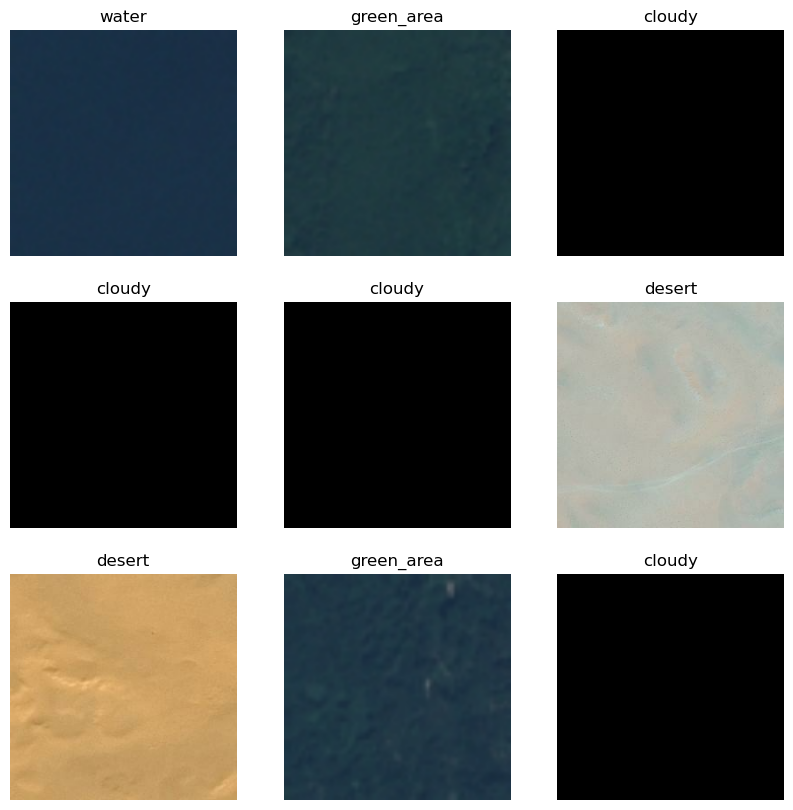

In [8]:
# Loop
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dataset = image_dataset_from_directory('/Users/weber/OneDrive/Área de Trabalho/PROFISSIONAL/DSA/AI/Lab3/Lab3 - Kaggle/data',
                                             shuffle=True,
                                             batch_size=32,image_size=(224,224))
class_name =  train_dataset.class_names
plt.figure(figsize = (10,10))
for image , label in train_dataset.take(1):
    for i in range(9) :
        plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(class_name[label[i]])
        plt.axis("off")

### Generate datasets

In [9]:
# Image
img_width, img_height = 224, 224
target_size = (img_width,img_height)
batch_size = 32

In [10]:
#Create a data generator for image augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator( samplewise_center=True,               # set each sample mean to 0
                             rotation_range=10,                     # randomly rotate images in the range (degrees, 0 to 180)
                             zoom_range = 0.1,                      # Randomly zoom imag
                             width_shift_range=0.1,                 # randomly shift images horizontally (fraction of total width)
                             height_shift_range=0.1,                # randomly shift images vertically (fraction of total height)
                             horizontal_flip=True,                  # randomly flip images
                             vertical_flip=False,
                             rescale=1./255,                        #scale images
                             validation_split=0.2)                  #split data, 80% for training and 20% for testing


### Training

In [11]:
#create training set from folders
train_data=datagen.flow_from_directory(data_dir,
                                       target_size=(target_size),
                                       batch_size=batch_size,
                                       class_mode='binary',
                                       shuffle=True,subset='training')


Found 4505 images belonging to 4 classes.


### Test

In [12]:
#create test set
test_data=datagen.flow_from_directory(data_dir,
                                       target_size=(target_size),
                                       batch_size=batch_size,
                                      class_mode='binary',
                                       shuffle=False,subset='validation')

Found 1126 images belonging to 4 classes.


### Based Model

In [13]:
from tensorflow.keras.applications.vgg19 import VGG19

vgg_model =  VGG19(include_top=True , weights='imagenet')
for models in vgg_model.layers:
    models.trainable= False

In [14]:
# Load the vgg19 model from keras
import keras
from keras.layers import Dense

vgg_model = keras.Model(inputs=vgg_model.input, outputs=vgg_model.layers[-2].output)
model = keras.Sequential()
for layer in vgg_model.layers:
    model.add(layer)

model.add(Dense(4, activation='softmax'))

In [15]:
# Copy vgg layers and add top layer
import tensorflow as tf

model.compile(optimizer="adam", loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

In [ ]:
FIT =model.fit(train_data,
    validation_data = test_data,
    callbacks = [early],
    epochs = 50)

Epoch 1/50
141/141 [==============================] - 383s 3s/step - loss: 1.2705 - accuracy: 0.4335 - val_loss: 1.0892 - val_accuracy: 0.4369
Epoch 2/50
141/141 [==============================] - ETA: 0s - loss: 0.9798 - accuracy: 0.6542

In [ ]:
model.evaluate(test_data)

In [ ]:
#y_true and y_pred
y_true = np.array([])
y_pred = np.array([])

i = 0
for data, labels in test_data:
    i += 1
    y = np.argmax(model.predict(data), axis=1)
    y_true = np.append(y_true, labels)
    y_pred = np.append(y_pred, y)
    if i == test_data.samples // 32 + 1:
        break

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn

cm  = confusion_matrix(y_pred,y_true)
df_cm = pd.DataFrame(cm, index =   ["cloud","desert" ,'green_area', 'water'],
              columns = ["cloud","desert" ,'green_area', 'water'])

seaborn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='d')
plt.title('confusion matrix')
plt.xlabel('prediction')
plt.ylabel('Actual')

In [ ]:
#plot the result
import matplotlib.pyplot as plt
acc = FIT.history['accuracy']
val_acc = FIT.history['val_accuracy']
loss = FIT.history['loss']
val_loss = FIT.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
#loss plot
plt.plot(epochs, loss, color='pink', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
model.save('Transfer_from_vgg19_model.keras')

# End